In [172]:
%matplotlib inline

In [282]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import shutil

### Loading images, Checking dimensions

In [174]:
! ls 

crop_faculty_pics                   faculty_pics
eigenfaces.ipynb                    haarcascade_frontalface_default.xml
face-alignment                      resized_faculty_pics
face-alignment.zip                  student_pics


Loading the pictures. We have 2 directories. 1 has all of USF MSAN's faculty headshots, other has student's headshots. 

In [175]:
path = '/Users/princegrover/Documents/msan/compstats/pca/'

In [176]:
student_pic_list = os.listdir(path + 'student_pics')
faculty_pic_list = os.listdir(path + 'faculty_pics')

In [177]:
len(student_pic_list), len(faculty_pic_list) # num students, num faculty

(79, 13)

In [178]:
student_pic_list[:2]

['avgerinou-danai.jpg', 'bowers-devin.jpg']

In [179]:
# shape of random student pic

plt.imread(path + 'student_pics/' + student_pic_list[1]).shape

(150, 150, 3)

In [180]:
# shape of random facult pic

plt.imread(path + 'faculty_pics/' + faculty_pic_list[1]).shape

(500, 500, 3)

Checking if dimension for all images in these 2 folders is same

In [181]:
# check if dimention of all images in student is same

i = 0
for st in range(len(student_pic_list)):
    arr = plt.imread(path + 'student_pics/' + student_pic_list[st])
    if (arr.shape[0] == 150) and (arr.shape[1] == 150):
        i += 1
assert i == len(student_pic_list)

In [182]:
# check if dimention of all images in faculty is same

i = 0
for st in range(len(faculty_pic_list)):
    arr = plt.imread(path + 'faculty_pics/' + faculty_pic_list[st])
    if (arr.shape[0] == 500) and (arr.shape[1] == 500):
        i += 1
assert i == len(faculty_pic_list)

In [183]:
student_pic_list[1]

'bowers-devin.jpg'

In [184]:
# funciton to plot 4 pictures in 1 row 

def plot_4_pics(dir_lst, dr):
    """
    Displays 4 random images from a directory of images
    
    dir_lst: list of image paths from where we want to show images
    dr: student_pics or faculty_pics
    
    """
    
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize = (12,5))
    
    # random 4 pictures from list
    np.random.seed(10)
    idxs = np.random.randint(0, len(dir_lst), 4)
    
    for i,idx in enumerate(idxs):
        p = path + dr + dir_lst[idx]
        img_ar = plt.imread(p)
        ax[i].imshow(img_ar)
        
        fig.suptitle(dr, y = 0.85, fontsize=15)
        fig.tight_layout()

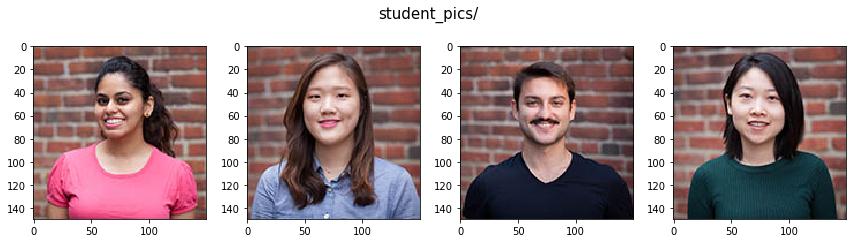

In [185]:
plot_4_pics(student_pic_list, 'student_pics/')

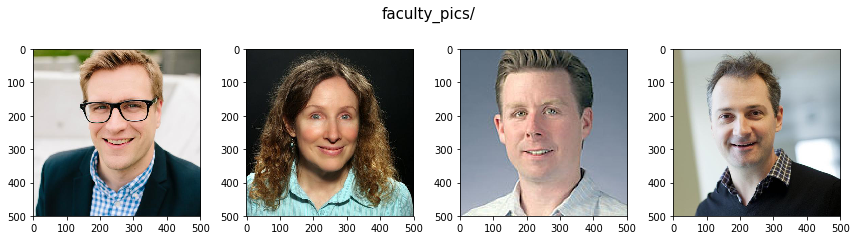

In [186]:
plot_4_pics(faculty_pic_list, 'faculty_pics/')

### Image pre-processing

#### Resizing images

Since all faculty images are 500x500 and we would like to have same dimension for all images. Resizing it. 

In [187]:
def resize(in_dir, out_dir, file_list , sz):
    """
    Resized all images from input directory to given sz and saves into output directory
    
    in_dir: path to input dir
    out_dir: path to output dir
    file_list: list of image paths to be resized
    sz: final size needed 
    
    """
    
    os.makedirs(out_dir, exist_ok=True) # create empty out_dir if not exist already
    
    for pic in file_list:
        ar  = cv2.imread(in_dir + pic)
        ar_out = cv2.resize(ar, (150,150))       
        cv2.imwrite(out_dir + pic, ar_out)

In [188]:
in_dir = path + 'faculty_pics/'
out_dir = path + 'resized_faculty_pics/'
resize(in_dir, out_dir, faculty_pic_list, 150)

In [189]:
resized_faculty_pic_list = os.listdir(path + 'resized_faculty_pics/')

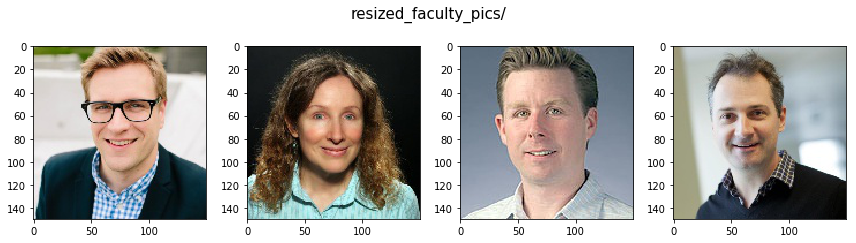

In [190]:
plot_4_pics(resized_faculty_pic_list, 'resized_faculty_pics/')

#### Cropping faces 
Code borrowed from http://gregblogs.com/computer-vision-cropping-faces-from-images-using-opencv2/

In [191]:
def facechop(in_dir, out_dir, file_lst):  
    """
    
    """
    os.makedirs(out_dir, exist_ok=True)

    facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)
    
    for i in file_lst:
        image = in_dir + i  # actual path of the image
        img = cv2.imread(image)
        faces = cascade.detectMultiScale(img)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

            sub_face = img[y:y+h, x:x+w]
            face_file_name = out_dir + str(y) + str(i)+ ".jpg"
            cv2.imwrite(face_file_name, sub_face)

        cv2.imshow(image, img)
    return None

In [163]:
# cropping faculty faces 

in_dir = path + 'resized_faculty_pics/'
out_dir = path + 'crop_faculty_pics/'
facechop(in_dir, out_dir, resized_faculty_pic_list)

Let's see how it looks like 

In [164]:
crop_faculty_pic_list = os.listdir(path + 'crop_faculty_pics/')

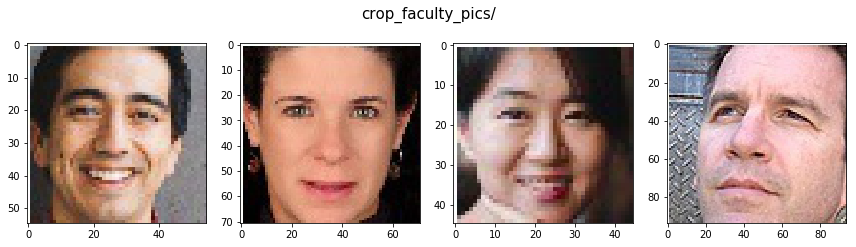

In [165]:
plot_4_pics(crop_faculty_pic_list, 'crop_faculty_pics/')

#### Aligning and cropped faces 

Eigen faces would give good results without aligning faces 
Taken from: https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

In [ ]:
python face-alignment/align_faces.py 
--shape-predictor face-alignment/shape_predictor_68_face_landmarks.dat 
--image faculty_pics/brizan-david-guy.jpg

In [197]:
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [345]:
def align_faces(in_dir, out_dir, file_lst, width = 150):
    
    """
    Align, crops faces and saves in output directory
    
    """
    
    os.makedirs(out_dir, exist_ok=True)
    
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor and the face aligner
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path + 'face-alignment/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=width)
    
    for file in file_lst:
        
        image_path = in_dir + file  # actual path of the image
        image = cv2.imread(image_path)
#         image = imutils.resize(image, width=150)
        convert = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # to RGB

        # show the original input image and detect faces in the grayscale
        # image
        cv2.imshow("Input", image)
        rects = detector(convert, 2)

        # loop over the face detections
        for rect in rects:
                # extract the ROI of the *original* face, then align the face
                # using facial landmarks
                (x, y, w, h) = rect_to_bb(rect)
                faceOrig = imutils.resize(image[y:y + h, x:x + w], width=width)
                faceAligned = fa.align(image, convert, rect)
                
                faceGray = np.stack((cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY),
                                     cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY),
                                     cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY)),
                                    axis=-1)
                
                cv2.imwrite(out_dir + file, faceGray)

In [346]:
# aligning, cropping faculty faces 

in_dir = path + 'faculty_pics/'
out_dir = path + 'align_faculty_pics/'
align_faces(in_dir, out_dir, faculty_pic_list)

In [285]:
# aligning, cropping students faces 

in_dir = path + 'student_pics/'
out_dir = path + 'align_student_pics/'
align_faces(in_dir, out_dir, student_pic_list)

**Let's visualize a few images now and see what alignment did**

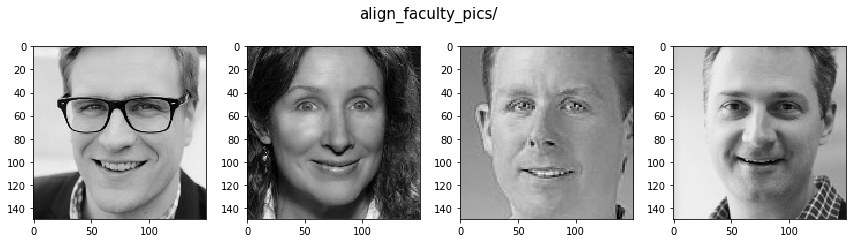

In [347]:
plot_4_pics(faculty_pic_list, 'align_faculty_pics/')

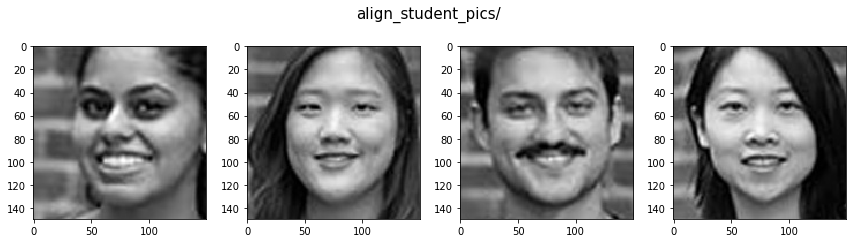

In [287]:
plot_4_pics(student_pic_list, 'align_student_pics/')

### Eigen faces

#### Step 1: Data matrix
We have collected pictures which are **aligned, face-cropped, converted to gray scale and all have same (h,w,c) dimentions. (i.e 150x150x3)**. This is very important step to get good eigen faces and also to regenrate faces at the end. Now, first step is to reshape each image into a vector of shape: (hxwxc,1). Then we create a matrix of data where each column represents an image vector. 

In [336]:
def create_data_matrix(in_dir, file_lst):
    """
    Creates a data matrix where each column correspond to image array vector of an image
    
    """
    
    sam_img_ar = plt.imread(in_dir + file_lst[0])
    dm = np.zeros((sam_img_ar.shape[0]*sam_img_ar.shape[1]*sam_img_ar.shape[2], len(file_lst)), dtype=np.float32) # initialize matrix r*g*b*c, num pics
    
    for i,f in enumerate(file_lst):
        img_ar = plt.imread(in_dir + f)
        dm[:,i] = img_ar.flatten()
    
    return dm 

In [348]:
in_dir = path + 'align_faculty_pics/'
faculty_dm  = create_data_matrix(in_dir, faculty_pic_list)

In [349]:
faculty_dm.shape

(67500, 13)

In [339]:
in_dir = path + 'align_student_pics/'
student_dm  = create_data_matrix(in_dir, student_pic_list)

In [340]:
student_dm.shape

(67500, 79)

#### Step 2: Normalizing image by subtracting from matrix mean

In order to get the average faculty and student face, we need to take the average of the column vectors for all images and reshape to visible format. 

Mean faculty face

In [350]:
mean_faculty = np.mean(faculty_dm, axis=1)
mean_faculty= mean_faculty[:,None]

In [351]:
faculty_dm_norm = faculty_dm - mean_faculty

In [352]:
faculty_dm_norm.shape

(67500, 13)

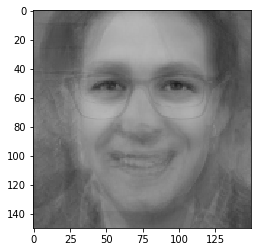

In [353]:
plt.imshow(mean_faculty.reshape((150,150,3))/255.)

Mean student face

In [330]:
mean_student = np.mean(student_dm, axis=1)
mean_student= mean_student[:,None]

In [331]:
student_dm_norm = student_dm - mean_student

In [332]:
student_dm_norm.shape

(67500, 79)

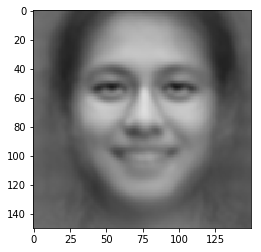

In [333]:
plt.imshow(mean_student.reshape((150,150,3))/255.)

#### Step 3: Getting eigen faces (eigen vectors) of normalized matrix. (aka Covariance matrix)  

Each eigenvector can be seen as an image itself and will have same dimension  of h,w,c. These eigen vectors are called eigen faces as each vector represents a face in itself. The matrix represents, how off each face vector is from mean face vector. The vectors represent `directions` in which each face vector vary from mean face.  